# Machine learning algorithm efficiency comparison with the same amount of information available for each model

## Data processing

---



### Importing of libraries

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from time import process_time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from time import perf_counter

### Importing of datasets

In [ ]:
training_set = pd.read_csv("Datasets/train_mosaic.csv")
test_set = pd.read_csv("Datasets/test_mosaic.csv")
sdn_set = pd.read_csv("Datasets/dataset_sdn.csv")

### Data pre-processing

The main goal here is to separate the data into two main parts:  features (X_train/X_test) and  labels (Y_train/Y_test). 

In [ ]:
Y_train_3_labels = pd.DataFrame(training_set, columns=["Label"])
X_train = training_set.copy()
del X_train["Label"]
Y_test_3_labels = pd.DataFrame(test_set, columns=["Label"])
X_test = test_set.copy()
del X_test["Label"]

There are several labels in this dataset (DoS Hulk, DoS slowloris, BENIGN).Indeed, as we want to predict DDoS attacks we don't really need to differentiate the 2 different types of attacks. As a consequence, the goal here is to process the dataset in order to have only 2 labels available: BENIGN and DDoS


In [ ]:
Y_train = []
Y_test = []
# Processing of the training set
for label in Y_train_3_labels["Label"]:
  if label=="DoS Hulk" or label=="DoS slowloris":
    Y_train.append("DDoS")
  else:
    Y_train.append("BENIGN")

# Processing of the test set
for label in Y_test_3_labels["Label"]:
  if label=="DoS Hulk" or label=="DoS slowloris":
    Y_test.append("DDoS")
  else:
    Y_test.append("BENIGN")
X_train.shape

(809361, 77)

### Noisy data removing

In this part, the main objective is to remove all the non relevant data that could reduce the performance of the machine learning algorithm. The first step is to delete all the features with negative values because it does not make sense in this context.

In [ ]:
del X_train["Init_Win_bytes_backward"]
del X_train["Init_Win_bytes_forward"]
del X_test["Init_Win_bytes_backward"]
del X_test["Init_Win_bytes_forward"]
X_train.shape

(809361, 75)

The next set is to remove the constant features because it means that the values do not have any influence on the model prediction. In fact, whether it is a DDoS attack or not the value still the same.

In [ ]:
index = [32, 33, 49, 55, 56, 57, 58, 59, 60]
for pos in index: 
  feature = X_train.columns[pos]
  del X_train[feature]
  del X_test[feature]
X_train.shape

(809361, 66)

### Dataset modification to determine the most efficient machine learning algorithm

The main goal of this code is to reduce the amount of data in the dataset. Indeed, we want to determine the most efficient model and we know that SVM performs with a reduced amount of information in order to provide a suitable processing time. Threrefore, the purpose is to determine if all the models are able to perform as good as the SVM model with a reduced version of the dataset.

In [ ]:
X_train = X_train.sample(frac=1/16)
X_test = X_test.sample(frac=1/16)
Y_train = (pd.DataFrame(Y_train).sample(frac=1/16)).values.ravel()
Y_test = (pd.DataFrame(Y_test).sample(frac=1/16)).values.ravel()
print("Train set X",X_train.shape)
print("Test set X",X_test.shape)
print("Train set Y",np.shape(Y_train)," | type : ",type(Y_train))
print("Test set Y",np.shape(Y_test)," | type : ",type(Y_test))

Train set X (50585, 66)
Test set X (21679, 66)
Train set Y (50585,)  | type :  <class 'numpy.ndarray'>
Test set Y (21679,)  | type :  <class 'numpy.ndarray'>


## Machine learning algorthm comparison (Random Forest, SVM, KNN, MLP)

The main goal of this program is to compare the performance between 4 different machine learning algorithms: SVM, Random Forest, KNN and MLP.Indeed, These algorithms raised suisatble performances for DDoS attack detection. 

Firstly, the purpose here is to use the PCA method in order to select the amount of information kept. Secondly, several metrics are measured to determine how the different models perform with the amount information selected. Finally, the measures are ploated on several graphs. 

In [ ]:
amoutOfInfo = [0.7,0.8,0.9,0.99,0.9999,0.99999,0.999999]
mlAlgorithms = ["RandomForest","KNN","MLP","SVM"]
featuresMeasured = ["Accuracy","Precision", "Recall", "TPR", "TNR", "FPR" , "FNR" , "Feature" , "ProcessingTime","PredictTime"]
measuresInfo = {
  "RandomForest" : {},
  "KNN" : {},
  "MLP" : {},
  "SVM" : {},
}

## data
for algorithm in mlAlgorithms:
  measuresInfo[algorithm] = {
      "Accuracy": [],
      "Precision": [],
      "Recall": [],
      "TPR": [],
      "TNR": [],
      "FPR": [],
      "FNR": [],
      "Feature": [],
      "ProcessingTime":[],
      "PredictTime":[],
  }


for algorithm in mlAlgorithms:
  print("_______________________",algorithm,"_____________________")
  for info in amoutOfInfo:
    ## feature selection
    print("-------- Experimentation ",info," --------------")

    ### Train set
    pca_autre = PCA(info)
    X_pca_99_ex = pca_autre.fit_transform(X_train)
    rows, columns = X_pca_99_ex.shape

    ### Test set
    pca_autre_test = PCA(columns)
    X_pca_99_test_ex = pca_autre_test.fit_transform(X_test)
    print(X_pca_99_test_ex.shape)

    ## Model

    ## Random Forest
    if algorithm == "RandomForest":
      rf_clf_pca_autre = ensemble.RandomForestClassifier(n_estimators=80)

      start = process_time()
      rf_clf_pca_autre.fit(X_pca_99_ex, Y_train)
      end = process_time()

      start_predict = process_time()
      Y_predict = rf_clf_pca_autre.predict(X_pca_99_test_ex)
      end_predict = process_time()

    ## KNN
    elif algorithm == "KNN":
      neigh = KNeighborsClassifier(n_neighbors=5)

      start = process_time()
      neigh.fit(X_pca_99_ex, Y_train)
      end = process_time()

      start_predict = process_time()
      Y_predict = neigh.predict(X_pca_99_test_ex)
      end_predict = process_time()
      
    ## SVM
    elif algorithm == "SVM":
      sv_clf = SVC(probability=True)

      start = process_time()
      sv_clf.fit(X_pca_99_ex, Y_train)
      end = process_time()

      start_predict = process_time()
      Y_predict = sv_clf.predict(X_pca_99_test_ex)
      end_predict = process_time()
    
    ## MLP
    else:
      clf = MLPClassifier(max_iter=600)

      start = process_time()
      clf.fit(X_pca_99_ex, Y_train)
      end = process_time()

      start_predict = process_time()
      Y_predict = clf.predict(X_pca_99_test_ex)
      end_predict = process_time()

    ## Metrics
    # Processing time
    training_time = end-start

    #Predict time
    predict_time = end_predict - start_predict

    # accuracy
    accuracy = accuracy_score(Y_test, Y_predict)
    print("Accuracy --> ",accuracy)

    # Precision
    precision = precision_score(Y_test, Y_predict, average='macro')
    print("Precision score --> ",precision)

    # Recall
    recall = recall_score(Y_test, Y_predict, average='macro')
    print("Recall score --> ",recall)

    # Confusion matrix
    matrix = confusion_matrix(Y_test, Y_predict, labels=["DDoS", "BENIGN"])
    print(matrix)

    # TPR, FPR
    FP = matrix[0][0]
    FN = matrix[1][0]
    TP = matrix[1][1]
    TN = matrix[0][1]

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    print("TPR --> ",TPR)
    print("TNR --> ",TNR)
    print("FPR --> ",FPR)
    print("FNR --> ",FNR)
    print("Processing time --> ",training_time)
    print("Predict time --> ",predict_time)
    print("-----------------")

    #Information storage
    measuresInfo[algorithm]["Accuracy"].append(accuracy)
    measuresInfo[algorithm]["Precision"].append(precision)
    measuresInfo[algorithm]["Recall"].append(recall)
    measuresInfo[algorithm]["TPR"].append(TPR)
    measuresInfo[algorithm]["TNR"].append(TNR)
    measuresInfo[algorithm]["FPR"].append(FPR)
    measuresInfo[algorithm]["FNR"].append(FNR)
    measuresInfo[algorithm]["Feature"].append(columns)
    measuresInfo[algorithm]["ProcessingTime"].append(training_time)
    measuresInfo[algorithm]["PredictTime"].append(predict_time)

_______________________ RandomForest _____________________
-------- Experimentation  0.7  --------------
(21679, 1)
Accuracy -->  0.4819871765302828
Precision score -->  0.5000251538867884
Recall score -->  0.5000199752148049
[[3162 8529]
 [2701 7287]]
TPR -->  0.7295754905887064
TNR -->  0.7295355401590967
FPR -->  0.2704644598409033
FNR -->  0.27042450941129353
Processing time -->  17.087297078
Predict time -->  0.4560380699999982
-----------------
-------- Experimentation  0.8  --------------
(21679, 2)
Accuracy -->  0.5235020065501176
Precision score -->  0.5015215852284916
Recall score -->  0.5010295692441057
[[9202 2489]
 [7841 2147]]
TPR -->  0.21495794953944733
TNR -->  0.21289881105123598
FPR -->  0.787101188948764
FNR -->  0.7850420504605526
Processing time -->  15.099530739000002
Predict time -->  0.38287350100000594
-----------------
-------- Experimentation  0.9  --------------
(21679, 3)
Accuracy -->  0.5210572443378385
Precision score -->  0.4995505514479388
Recall score

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall score -->  0.5
[[    0 11691]
 [    0  9988]]
TPR -->  1.0
TNR -->  1.0
FPR -->  0.0
FNR -->  0.0
Processing time -->  9.185361962000002
Predict time -->  0.03775650099998984
-----------------
-------- Experimentation  0.8  --------------
(21679, 2)
Accuracy -->  0.5219336685271461
Precision score -->  0.5045121460797265
Recall score -->  0.5035423784737049
[[8624 3067]
 [7297 2691]]
TPR -->  0.2694233079695635
TNR -->  0.2623385510221538
FPR -->  0.7376614489778462
FNR -->  0.7305766920304365
Processing time -->  10.114630192999982
Predict time -->  0.03609463599997298
-----------------
-------- Experimentation  0.9  --------------
(21679, 3)
Accuracy -->  0.4645509479219521
Precision score -->  0.5097021467370637
Recall score -->  0.5012454257400387
[[  399 11292]
 [  316  9672]]
TPR -->  0.9683620344413296
TNR -->  0.9658711829612523
FPR -->  0.034128817038747754
FNR -->  0.031637965558670406
Processing time -->  16.760855166
Predict time -->  0.03713441000002149
------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall score -->  0.5
[[11691     0]
 [ 9988     0]]
TPR -->  0.0
TNR -->  0.0
FPR -->  1.0
FNR -->  1.0
Processing time -->  598.3454796369999
Predict time -->  52.40981618699993
-----------------
-------- Experimentation  0.8  --------------
(21679, 2)
Accuracy -->  0.5392776419576548
Precision score -->  0.2696388209788274


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall score -->  0.5
[[11691     0]
 [ 9988     0]]
TPR -->  0.0
TNR -->  0.0
FPR -->  1.0
FNR -->  1.0
Processing time -->  650.0313665229999
Predict time -->  51.727851741999984
-----------------
-------- Experimentation  0.9  --------------
(21679, 3)
Accuracy -->  0.539231514368744
Precision score -->  0.514958409601301
Recall score -->  0.5001468274631636
[[11664    27]
 [ 9962    26]]
TPR -->  0.002603123748498198
TNR -->  0.0023094688221709007
FPR -->  0.9976905311778291
FNR -->  0.9973968762515018
Processing time -->  734.1953087660002
Predict time -->  52.56330649900019
-----------------
-------- Experimentation  0.99  --------------
(21679, 7)
Accuracy -->  0.5390008764241893
Precision score -->  0.5132577377682551
Recall score -->  0.5005601110178335
[[11573   118]
 [ 9876   112]]
TPR -->  0.011213456147376852
TNR -->  0.010093234111709863
FPR -->  0.9899067658882902
FNR -->  0.9887865438526231
Processing time -->  1221.057425775
Predict time -->  56.81511208999973
--------

DataFrame export

In [ ]:
measuresInfoDF = pd.DataFrame(measuresInfo)
measuresInfoDF.to_csv('Results/efficiency comparison/results.csv') 

Display of the metrics

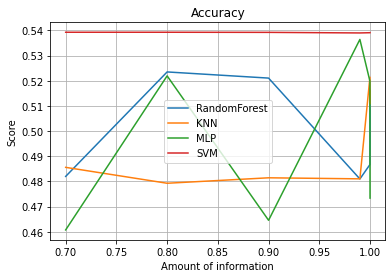

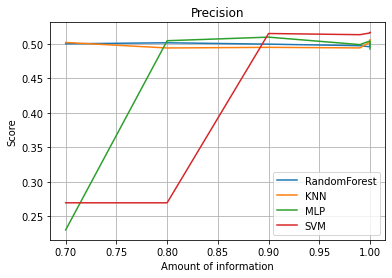

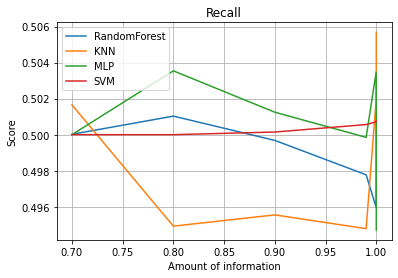

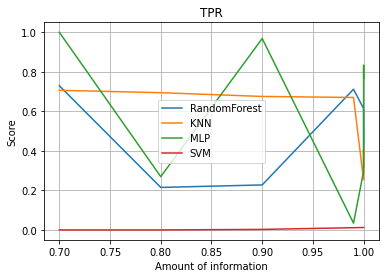

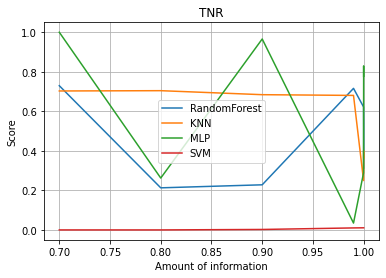

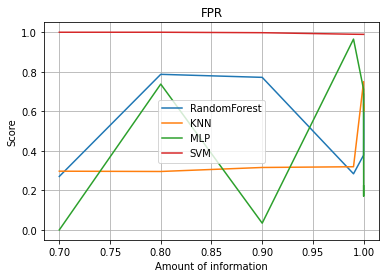

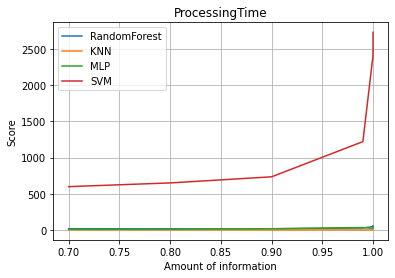

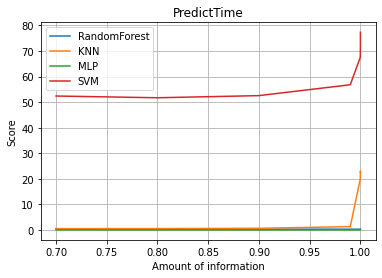

In [ ]:
compteur=0
for feature in featuresMeasured:
  plt.figure(compteur)
  for algorithm in mlAlgorithms:
    plt.plot(amoutOfInfo,measuresInfo[algorithm][feature],label=algorithm)
  plt.grid(True)
  plt.xlabel("Amount of information")
  plt.ylabel("Score")
  plt.legend()
  plt.title(feature)
  chemin = "Results/efficiency comparison/"+feature+".png"
  plt.savefig(chemin)
  compteur+=1